# Boosting in Cox Regression

## Load libraries

In [1]:
## load the required packages

# clear all workspace
rm(list=ls()) 
# install the necessary packages
library("mlr3")
library("mlr3proba")
library("mlr3learners")
library("mlr3extralearners")
library("data.table")
library("mlr3viz")
library("mlr3tuning")
library("mlr3pipelines")
library("purrr")
library("mboost")
library("CoxBoost")
library("survival")
library("paradox")
library("ggrepel")
library("precrec")
library("ggplot2")
library("ggpubr")
library("tidyverse")
library("mlr3filters")
library("ranger")


Attaching package: ‘mlr3extralearners’


The following object is masked from ‘package:mlr3learners’:

    LearnerClassifNnet


The following objects are masked from ‘package:mlr3’:

    lrn, lrns


Loading required package: paradox


Attaching package: ‘purrr’


The following object is masked from ‘package:data.table’:

    transpose


Loading required package: parallel

Loading required package: stabs

Loading required package: survival

Loading required package: Matrix

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:mboost’:

    %+%


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::%+%()     masks mboost::%+%()
✖ dplyr::between()   masks data.table::between()
✖ tidyr::expand()    masks M

## Create the task for d5

In [2]:
# read in the raw data
train_data_original <- readRDS("~/Prediction_Challenge_T2E_ML/Data-20210107/train_data.Rds")

In [3]:
# get the corresponding dataframe1
train_data_d5 <- train_data_original$d5

In [4]:
## create the corresponding task as for dataframe 1
tsks_train_d5 <- TaskSurv$new("df5", backend = train_data_original$d5, time = "time", event = "status")
## check the task
tsks_train_d5

<TaskSurv:df5> (1782 x 81)
* Target: time, status
* Properties: -
* Features (79):
  - dbl (79): V1, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V2,
    V20, V21, V22, V23, V24, V25, V26, V27, V28, V29, V3, V30, V31,
    V32, V33, V34, V35, V36, V37, V38, V39, V4, V40, V41, V42, V43,
    V44, V45, V46, V47, V48, V49, V5, V50, V51, V52, V53, V54, V55,
    V56, V57, V58, V59, V6, V60, V61, V62, V63, V64, V65, V66, V67,
    V68, V69, V7, V70, V71, V72, V73, V74, V75, V76, V77, V78, V79, V8,
    V9

### Feature filtering
There are unobserved levels appearing when it comes to cross validation. Thus either `droplevels()` or do feature filtering.

In [5]:
###### feature filtering ######
library("mlr3filters") # load the required library
library("ranger")

lrn = lrn("surv.ranger")
lrn$param_set$values = list(importance = "impurity")

# set up the filter
filter = flt("importance", learner = lrn)
filter$calculate(tsks_train_d5) # calculate the corresponding importance scores
c_tab <- as.data.table(filter)

In [7]:
# select the importance scores with >10
c_var = c_tab$feature[c_tab$score >= 10]
c_var = as.vector(c_var)
c_var = append(c_var, c("time", "status"))
c_var

[1] "V1"     "V2"     "V6"     "V5"     "V3"     "V4"     "V52"    "V54"   
 [9] "V64"    "V58"    "V73"    "time"   "status"

In [9]:
## subset the train data
train_flt_d5 <- subset(train_data_d5, select=c_var)
train_flt_d5

,V1,V2,V6,V5,V3,V4,V52,V54,V64,V58,V73,time,status
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,75.65,22,6.04,16,10,2,1,0,1,0,0,2999,0
2,43.19,10,4.02,25,0,1,1,0,1,0,0,1484,0
3,48.87,15,4.03,12,1,2,1,0,1,1,0,3053,0
4,47.68,25,4.05,21,3,2,0,1,1,1,0,1721,0
5,76.97,40,6.08,8,8,2,1,0,0,1,0,1241,1
6,78.77,31,4.06,14,0,4,0,1,0,1,0,234,1
7,56.45,10,4.02,26,1,2,0,1,1,1,0,2947,0
8,70.00,65,6.13,11,7,3,1,0,1,0,0,672,1
9,89.08,29,4.06,24,1,2,0,1,1,1,0,2734,1


In [10]:
# update the task
tsks_flt_d5 <- TaskSurv$new("df5", backend = train_flt_d5, time = "time", event = "status")
## check the task
tsks_flt_d5

<TaskSurv:df5> (1782 x 13)
* Target: time, status
* Properties: -
* Features (11):
  - dbl (11): V1, V2, V3, V4, V5, V52, V54, V58, V6, V64, V73

## Hyperparameter Tuning for `d5`


In [11]:
## load the learner for the aft boosting and design the benchmark
## Step 1_1: Try with a default setting
design <- benchmark_grid(
  tasks = tsks_flt_d5,
  learners = lrn("surv.mboost", baselearner = "bols", family = "weibull"), # cannot compute ‘bbs’ for non-numeric variables; used ‘bols’ instead.
  resampling = rsmp("cv", folds = 3L)
)


# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
aft_bmr <- run_benchmark(design)

INFO  [23:43:59.014] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [23:43:59.165] [mlr3]  Applying learner 'surv.mboost' on task 'df5' (iter 2/3) 
INFO  [23:44:00.716] [mlr3]  Applying learner 'surv.mboost' on task 'df5' (iter 3/3) 
INFO  [23:44:01.871] [mlr3]  Applying learner 'surv.mboost' on task 'df5' (iter 1/3) 
INFO  [23:44:02.963] [mlr3]  Finished benchmark 


In [12]:
# set the global evaluation metric
all_measures <- msr("surv.cindex")

# evaluate the performance with the IBS score
aft_results <- aft_bmr$aggregate(measures = all_measures)
aft_results # 0.643

nr,resample_result,task_id,learner_id,resampling_id,iters,surv.harrell_c
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x55a5e7e29fd0>,df5,surv.mboost,cv,3,0.642964


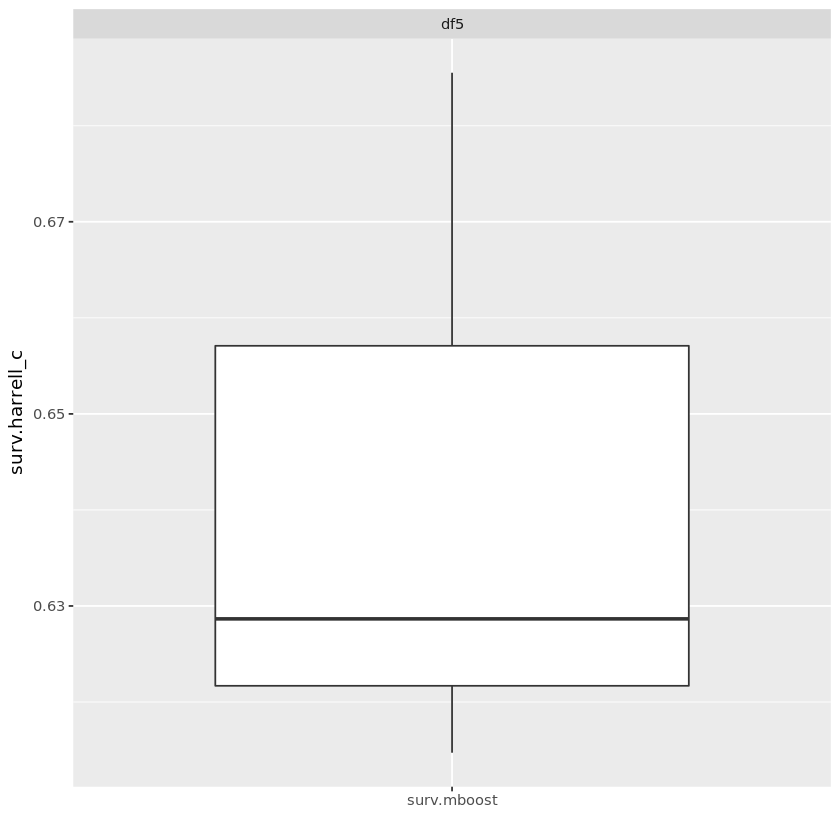

In [13]:
# plot the benchmark result with a default setting
autoplot(aft_bmr)

Step 1_2: Fine_tuning

In [14]:
# load the learner with aft
lrn_aft <- lrn("surv.mboost", baselearner = 'bols', family = "weibull")
# train with "baselearner"
base_learner_type <- c("bols", "btree")
family_type <- c("weibull", "loglog", "lognormal")

# set the search space
param_aft_bl <- ParamSet$new(params = list(
  ParamFct$new("baselearner", levels = base_learner_type),
  ParamFct$new("family", levels = family_type),
  ParamInt$new("mstop", lower = 50, upper = 300),
  ParamDbl$new("nu", lower = 0.05, upper = 0.5)
))

# inner resampling set
inner_rsmp <- rsmp("cv", folds = 3L)

# create the AutoTuner
grid_auto_aft <- AutoTuner$new(
  learner = lrn_aft, resampling = inner_rsmp,
  measure = msr("surv.cindex"), search_space = param_aft_bl,
  terminator = trm("evals", n_evals = 20), tuner = tnr("grid_search", resolution = 5)
)
# set the outer resampling
outer_rsmp <- rsmp("cv", folds = 3L)
# design the benchmark with bf
# design_aft_bl <- benchmark_grid(
#   tasks = tsks_train_d1,
#   learners = aft_bl,
#   resamplings = outer_rsmp
# )
aft_bmr_2 = resample(tsks_flt_d5, grid_auto_aft, outer_rsmp, store_models = TRUE)

INFO  [23:45:10.306] [mlr3]  Applying learner 'surv.mboost.tuned' on task 'df5' (iter 2/3) 
INFO  [23:45:10.371] [bbotk] Starting to optimize 4 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=20]' 
INFO  [23:45:10.378] [bbotk] Evaluating 1 configuration(s) 
INFO  [23:45:10.408] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [23:45:10.421] [mlr3]  Applying learner 'surv.mboost' on task 'df5' (iter 2/3) 
INFO  [23:45:15.918] [mlr3]  Applying learner 'surv.mboost' on task 'df5' (iter 1/3) 
INFO  [23:45:21.130] [mlr3]  Applying learner 'surv.mboost' on task 'df5' (iter 3/3) 
INFO  [23:45:26.289] [mlr3]  Finished benchmark 
INFO  [23:45:26.343] [bbotk] Result of batch 1: 
INFO  [23:45:26.347] [bbotk]  baselearner  family mstop     nu surv.harrell_c 
INFO  [23:45:26.347] [bbotk]        btree weibull   175 0.1625      0.6694525 
INFO  [23:45:26.347] [bbotk]                                 uhash 
INFO  [23:45:26.347] [bbotk]  a1d0a6d7-50da-46e7-b4eb-cb2d80cf6f1

In [15]:
# evaluate the performance
aft_bmr_2$aggregate(measures = msr("surv.cindex")) # 0.675

surv.harrell_c 
      0.675112

In [16]:
## optimal hyperparameters found by grid search
aft_bmr_2$learners[[1]]$tuning_result$learner_param_vals

[[1]]
[[1]]$family
[1] "loglog"

[[1]]$baselearner
[1] "btree"

[[1]]$mstop
[1] 50

[[1]]$nu
[1] 0.3875

Step_1_3: autoplot the pre and tuned benchmark results

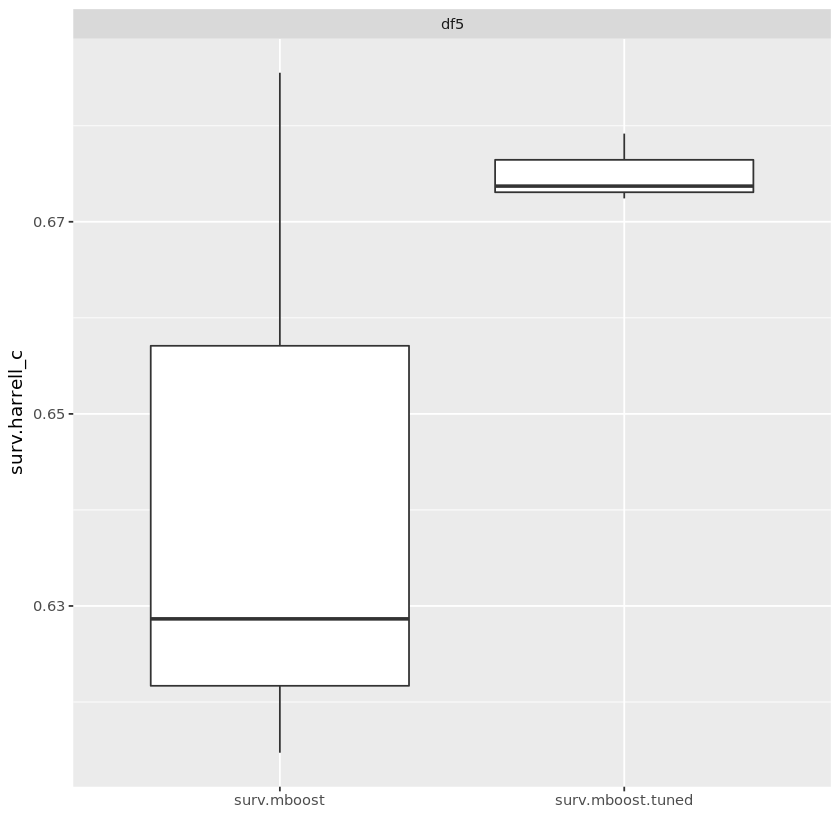

In [17]:
# autoplot the two boxplots
autoplot(c(aft_bmr,aft_bmr_2))

#### Step 2: mboost
Step 2_1: Try with a default setting

In [18]:
design <- benchmark_grid(
  tasks = tsks_flt_d5,
  learners = lrn("surv.mboost", baselearner = 'bols', family = "coxph"), # cannot compute ‘bbs’ for non-numeric variables; used ‘bols’ instead.
  resampling = rsmp("cv", folds = 3L)
)


# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
mb_bmr <- run_benchmark(design)

INFO  [23:57:57.587] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [23:57:57.596] [mlr3]  Applying learner 'surv.mboost' on task 'df5' (iter 2/3) 
INFO  [23:58:28.011] [mlr3]  Applying learner 'surv.mboost' on task 'df5' (iter 3/3) 
INFO  [23:58:54.618] [mlr3]  Applying learner 'surv.mboost' on task 'df5' (iter 1/3) 
INFO  [23:59:20.399] [mlr3]  Finished benchmark 


In [19]:
mb_bmr_results <- mb_bmr$aggregate(msr("surv.cindex"))
mb_bmr_results # 0.645

nr,resample_result,task_id,learner_id,resampling_id,iters,surv.harrell_c
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x55a5e473bc18>,df5,surv.mboost,cv,3,0.6466208


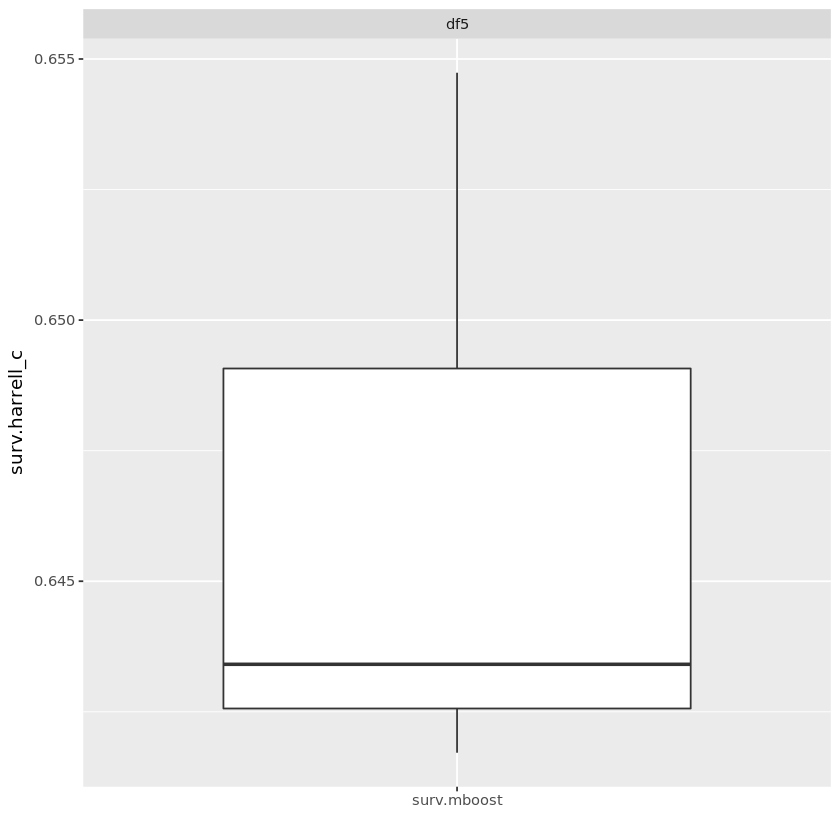

In [20]:
# plot the boxplots
autoplot(mb_bmr)

Step 2_2: Fine_tuning

In [23]:
# load the learner with mboost
lrn_mb <- lrn("surv.mboost", baselearner = 'bols', family = "coxph")
# train with "baselearner"
base_learner_type <- c("bols", "btree")
family_type <- c("cindex", "coxph")

# set the search space
param_mb <- ParamSet$new(params = list(
  ParamFct$new("baselearner", levels = base_learner_type),
  ParamFct$new("family", levels = family_type),
  ParamInt$new("mstop", lower = 50, upper = 200),
  ParamDbl$new("nu", lower = 0.05, upper = 0.5)
))

# inner resampling set
inner_rsmp <- rsmp("cv", folds = 2L)

# create the AutoTuner
grid_auto_mb <- AutoTuner$new(
  learner = lrn_mb, resampling = inner_rsmp,
  measure = msr("surv.cindex"), search_space = param_mb,
  terminator = trm("evals", n_evals = 20), tuner = tnr("grid_search", resolution = 5)
)
# set the outer resampling
outer_rsmp <- rsmp("cv", folds = 2L)
# design the benchmark with bf
# design_aft_bl <- benchmark_grid(
#   tasks = tsks_train_d1,
#   learners = aft_bl,
#   resamplings = outer_rsmp
# )
mb_bmr_2 = resample(tsks_flt_d5, grid_auto_mb, outer_rsmp, store_models = TRUE)
## pretty slow when setting inner_rsmp and outer_rsmp to be 3L at the same time

INFO  [00:27:22.201] [mlr3]  Applying learner 'surv.mboost.tuned' on task 'df5' (iter 2/2) 
INFO  [00:27:22.235] [bbotk] Starting to optimize 4 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=20]' 
INFO  [00:27:22.239] [bbotk] Evaluating 1 configuration(s) 
INFO  [00:27:22.265] [mlr3]  Benchmark with 2 resampling iterations 
INFO  [00:27:22.274] [mlr3]  Applying learner 'surv.mboost' on task 'df5' (iter 1/2) 
INFO  [00:27:29.468] [mlr3]  Applying learner 'surv.mboost' on task 'df5' (iter 2/2) 
INFO  [00:27:36.823] [mlr3]  Finished benchmark 
INFO  [00:27:36.868] [bbotk] Result of batch 1: 
INFO  [00:27:36.871] [bbotk]  baselearner family mstop    nu surv.harrell_c 
INFO  [00:27:36.871] [bbotk]         bols  coxph    50 0.275      0.6463975 
INFO  [00:27:36.871] [bbotk]                                 uhash 
INFO  [00:27:36.871] [bbotk]  cccca829-d9a6-45ba-bb67-d6ad8675c7ce 
INFO  [00:27:36.873] [bbotk] Evaluating 1 configuration(s) 
INFO  [00:27:36.899] [mlr3]

In [24]:
# evaluate the performance
mb_bmr_2$aggregate() # 0.658

surv.harrell_c 
     0.6584318

In [25]:
## optimal hyperparameters found by grid search
mb_bmr_2$learners[[1]]$tuning_result$learner_param_vals

[[1]]
[[1]]$family
[1] "coxph"

[[1]]$baselearner
[1] "btree"

[[1]]$mstop
[1] 200

[[1]]$nu
[1] 0.275

Step_1_3: boxplot the pre and after

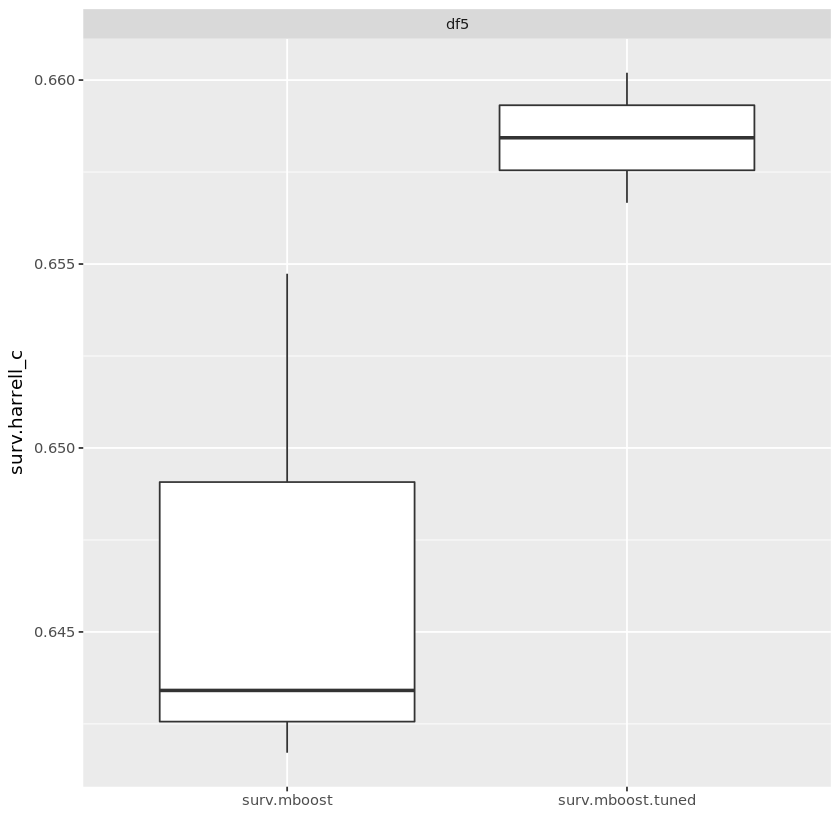

In [26]:
# autoplot the two boxplots
autoplot(c(mb_bmr,mb_bmr_2))

#### Step 3: CoxBoost
Step 3_1: Data Preprocessing to encode the nominal variables

In [27]:
tsks_flt_d5 # only dbl

<TaskSurv:df5> (1782 x 13)
* Target: time, status
* Properties: -
* Features (11):
  - dbl (11): V1, V2, V3, V4, V5, V52, V54, V58, V6, V64, V73

Step 3_2: Try with a default setting

In [29]:
library("pracma")

In [30]:
install_learners('surv.coxboost')

In [31]:
design <- benchmark_grid(
  tasks = tsks_flt_d5,
  learners = lrn("surv.coxboost", criterion="hpscore"),
  resampling = rsmp("cv", folds = 3L)
)

# lrn("surv.coxboost")$param_set

# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
cb_bmr <- run_benchmark(design)


# set the global evaluation metric
all_measures <- msr("surv.cindex")

cb_results <- cb_bmr$aggregate(measures = all_measures)
cb_results # 0.646

INFO  [00:42:51.028] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [00:42:51.040] [mlr3]  Applying learner 'surv.coxboost' on task 'df5' (iter 2/3) 
INFO  [00:43:42.850] [mlr3]  Applying learner 'surv.coxboost' on task 'df5' (iter 3/3) 
INFO  [00:44:33.726] [mlr3]  Applying learner 'surv.coxboost' on task 'df5' (iter 1/3) 
INFO  [00:45:24.177] [mlr3]  Finished benchmark 


nr,resample_result,task_id,learner_id,resampling_id,iters,surv.harrell_c
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x55a637a2a9f0>,df5,surv.coxboost,cv,3,0.6455331


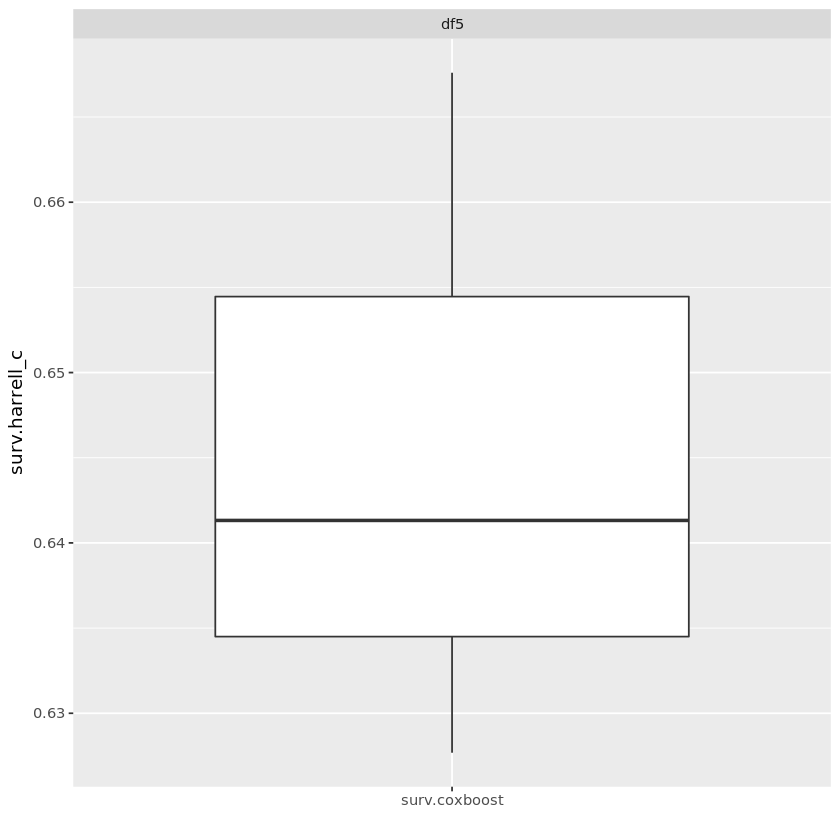

In [33]:
# plot the corresponding the performance
autoplot(cb_bmr)

Step_3_3: Fine-tuning with CoxBoost

In [34]:
# load the learner with CoxBoost
lrn_cb <- lrn("surv.coxboost", criterion="hpscore")
# from 50-250, 100-300, 150-250

# set the search space
param_cb <- ParamSet$new(params = list(
  ParamInt$new("stepno", lower = 50, upper = 250),
  ParamDbl$new("penalty", lower = 100, upper = 500),
  ParamDbl$new("stepsize.factor", lower = 0.1, upper = 10)
))

# inner resampling set
inner_rsmp <- rsmp("cv", folds = 2L)

# create the AutoTuner
grid_auto_cb <- AutoTuner$new(
  learner = lrn_cb, resampling =  inner_rsmp,
  measure = msr("surv.cindex"), search_space = param_cb,
  terminator = trm("evals", n_evals = 20), tuner = tnr("grid_search", resolution = 5)
)
# set the outer resampling
outer_rsmp <- rsmp("cv", folds = 2L)

cb_bmr_2 = resample(tsks_flt_d5, grid_auto_cb, outer_rsmp, store_models = TRUE)

INFO  [00:46:28.604] [mlr3]  Applying learner 'surv.coxboost.tuned' on task 'df5' (iter 2/2) 
INFO  [00:46:28.652] [bbotk] Starting to optimize 3 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=20]' 
INFO  [00:46:28.657] [bbotk] Evaluating 1 configuration(s) 
INFO  [00:46:28.694] [mlr3]  Benchmark with 2 resampling iterations 
INFO  [00:46:28.707] [mlr3]  Applying learner 'surv.coxboost' on task 'df5' (iter 1/2) 
INFO  [00:46:46.466] [mlr3]  Applying learner 'surv.coxboost' on task 'df5' (iter 2/2) 
INFO  [00:47:00.111] [mlr3]  Finished benchmark 
INFO  [00:47:00.155] [bbotk] Result of batch 1: 
INFO  [00:47:00.157] [bbotk]  stepno penalty stepsize.factor surv.harrell_c 
INFO  [00:47:00.157] [bbotk]     100     300             0.1      0.6321977 
INFO  [00:47:00.157] [bbotk]                                 uhash 
INFO  [00:47:00.157] [bbotk]  d0e4cb27-a34e-4652-89d1-3be64d06b94a 
INFO  [00:47:00.159] [bbotk] Evaluating 1 configuration(s) 
INFO  [00:47:00.185] 

In [35]:
# evaluate the performance
cb_bmr_2$aggregate() # 0.645

surv.harrell_c 
     0.6468175

In [36]:
## optimal hyperparameters found by grid search
cb_bmr_2$learners[[1]]$tuning_result$learner_param_vals	

[[1]]
[[1]]$criterion
[1] "hpscore"

[[1]]$stepno
[1] 150

[[1]]$penalty
[1] 200

[[1]]$stepsize.factor
[1] 0.1

Step_3_4: Autoplot the pre and after tuning boxplots

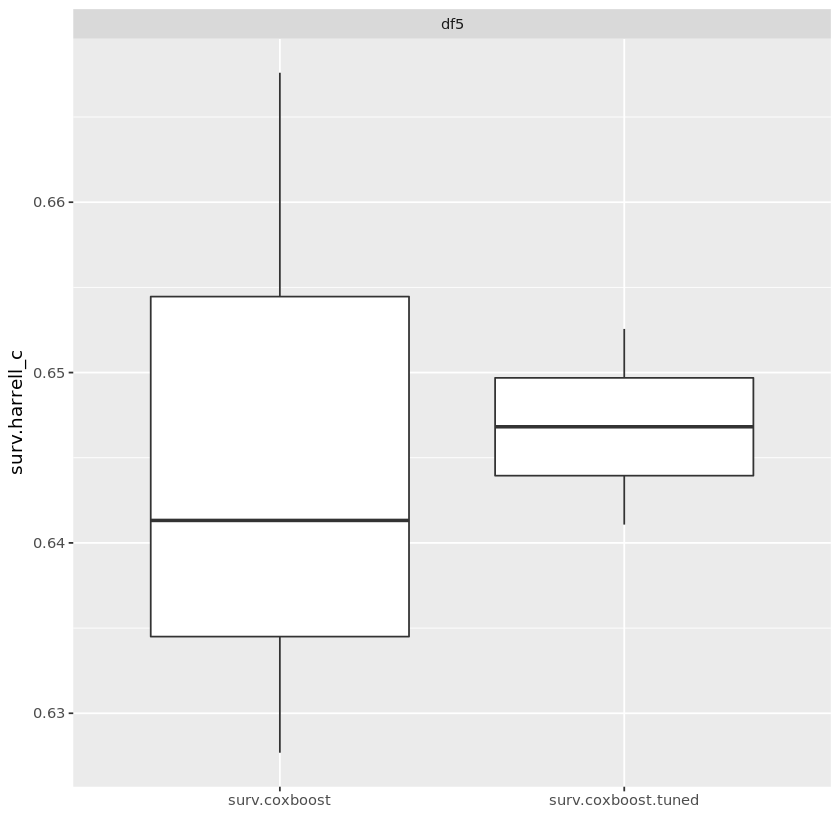

In [37]:
# autoplot the two boxplots
autoplot(c(cb_bmr,cb_bmr_2))